In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Convolutional Neural Networks

In <<chapter_mnist_basics>> we learned how to create a neural network recognizing images. We were able to achieve a bit over 98% accuracy at distinguishing 3s from 7s—but we also saw that fastai's built-in classes were able to get close to 100%. Let's start trying to close the gap.

In this chapter, we will begin by digging into what convolutions are and building a CNN from scratch. We will then study a range of techniques to improve training stability and learn all the tweaks the library usually applies for us to get great results.

## The Magic of Convolutions

One of the most powerful tools that machine learning practitioners have at their disposal is *feature engineering*. A *feature* is a transformation of the data which is designed to make it easier to model. For instance, the `add_datepart` function that we used for our tabular dataset preprocessing in <<chapter_tabular>> added date features to the Bulldozers dataset. What kinds of features might we be able to create from images?

> jargon: Feature engineering: Creating new transformations of the input data in order to make it easier to model.

In the context of an image, a feature is a visually distinctive attribute. For example, the number 7 is characterized by a horizontal edge near the top of the digit, and a top-right to bottom-left diagonal edge underneath that. On the other hand, the number 3 is characterized by a diagonal edge in one direction at the top left and bottom right of the digit, the opposite diagonal at the bottom left and top right, horizontal edges at the middle, top, and bottom, and so forth. So what if we could extract information about where the edges occur in each image, and then use that information as our features, instead of raw pixels?

It turns out that finding the edges in an image is a very common task in computer vision, and is surprisingly straightforward. To do it, we use something called a *convolution*. A convolution requires nothing more than multiplication, and addition—two operations that are responsible for the vast majority of work that we will see in every single deep learning model in this book!

A convolution applies a *kernel* across an image. A kernel is a little matrix, such as the 3×3 matrix in the top right of <<basic_conv>>.

<img src="images/chapter9_conv_basic.png" id="basic_conv" caption="Applying a kernel to one location" alt="Applying a kernel to one location" width="700">

The 7×7 grid to the left is the *image* we're going to apply the kernel to. The convolution operation multiplies each element of the kernel by each element of a 3×3 block of the image. The results of these multiplications are then added together. The diagram in <<basic_conv>> shows an example of applying a kernel to a single location in the image, the 3×3 block around cell 18.

Let's do this with code. First, we create a little 3×3 matrix like so:

In [3]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

We're going to call this our kernel (because that's what fancy computer vision researchers call these). And we'll need an image, of course:

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

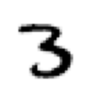

In [6]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

Now we're going to take the top 3×3-pixel square of our image, and multiply each of those values by each item in our kernel. Then we'll add them up, like so:

In [7]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [8]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

Not very interesting so far—all the pixels in the top-left corner are white. But let's pick a couple of more interesting spots:

In [9]:
#hide_output
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


<img alt="Top section of a digit" width="490" src="images/att_00059.png">

There's a top edge at cell 5,8. Let's repeat our calculation there:

In [10]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

There's a right edge at cell 8,18. What does that give us?:

In [11]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

As you can see, this little calculation is returning a high number where the 3×3-pixel square represents a top edge (i.e., where there are low values at the top of the square, and high values immediately underneath). That's because the `-1` values in our kernel have little impact in that case, but the `1` values have a lot.

Let's look a tiny bit at the math. The filter will take any window of size 3×3 in our images, and if we name the pixel values like this:

$$\begin{matrix} a1 & a2 & a3 \\ a4 & a5 & a6 \\ a7 & a8 & a9 \end{matrix}$$

it will return $-a1-a2-a3+a7+a8+a9$. If we are in a part of the image where $a1$, $a2$, and $a3$ add up to the same as $a7$, $a8$, and $a9$, then the terms will cancel each other out and we will get 0. However, if $a7$ is greater than $a1$, $a8$ is greater than $a2$, and $a9$ is greater than $a3$, we will get a bigger number as a result. So this filter detects horizontal edges—more precisely, edges where we go from bright parts of the image at the top to darker parts at the bottom.

Changing our filter to have the row of `1`s at the top and the `-1`s at the bottom would detect horizontal edges that go from dark to light. Putting the `1`s and `-1`s in columns versus rows would give us filters that detect vertical edges. Each set of weights will produce a different kind of outcome.

Let's create a function to do this for one location, and check it matches our result from before:

In [12]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [13]:
apply_kernel(5,7,top_edge)

tensor(762.)

But note that we can't apply it to the corner (e.g., location 0,0), since there isn't a complete 3×3 square there.

### Mapping a Convolution Kernel

We can map `apply_kernel()` across the coordinate grid. That is, we'll be taking our 3×3 kernel, and applying it to each 3×3 section of our image. For instance, <<nopad_conv>> shows the positions a 3×3 kernel can be applied to in the first row of a 5×5 image.

<img src="images/chapter9_nopadconv.svg" id="nopad_conv" caption="Applying a kernel across a grid" alt="Applying a kernel across a grid" width="400">

To get a grid of coordinates we can use a *nested list comprehension*, like so:

In [14]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

> note: Nested List Comprehensions: Nested list comprehensions are used a lot in Python, so if you haven't seen them before, take a few minutes to make sure you understand what's happening here, and experiment with writing your own nested list comprehensions.

Here's the result of applying our kernel over a coordinate grid:

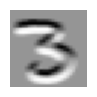

In [15]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

Looking good! Our top edges are black, and bottom edges are white (since they are the *opposite* of top edges). Now that our image contains negative numbers too, `matplotlib` has automatically changed our colors so that white is the smallest number in the image, black the highest, and zeros appear as gray.

We can try the same thing for left edges:

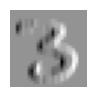

In [16]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

As we mentioned before, a convolution is the operation of applying such a kernel over a grid in this way. In the paper ["A Guide to Convolution Arithmetic for Deep Learning"](https://arxiv.org/abs/1603.07285) there are many great diagrams showing how image kernels can be applied. Here's an example from the paper showing (at the bottom) a light blue 4×4 image, with a dark blue 3×3 kernel being applied, creating a 2×2 green output activation map at the top. 

<img alt="Result of applying a 3×3 kernel to a 4×4 image" width="782" caption="Result of applying a 3×3 kernel to a 4×4 image (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_ex_four_conv" src="images/att_00028.png">

Look at the shape of the result. If the original image has a height of `h` and a width of `w`, how many 3×3 windows can we find? As you can see from the example, there are `h-2` by `w-2` windows, so the image we get has a result as a height of `h-2` and a width of `w-2`.

We won't implement this convolution function from scratch, but use PyTorch's implementation instead (it is way faster than anything we could do in Python).

### Convolutions in PyTorch

Convolution is such an important and widely used operation that PyTorch has it built in. It's called `F.conv2d` (recall that `F` is a fastai import from `torch.nn.functional`, as recommended by PyTorch). The PyTorch docs tell us that it includes these parameters:

- input:: input tensor of shape `(minibatch, in_channels, iH, iW)`
- weight:: filters of shape `(out_channels, in_channels, kH, kW)`

Here `iH,iW` is the height and width of the image (i.e., `28,28`), and `kH,kW` is the height and width of our kernel (`3,3`). But apparently PyTorch is expecting rank-4 tensors for both these arguments, whereas currently we only have rank-2 tensors (i.e., matrices, or arrays with two axes).

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [17]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

To test this, we'll need a `DataLoader` and a sample mini-batch. Let's use the data block API:

In [18]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

By default, fastai puts data on the GPU when using data blocks. Let's move it to the CPU for our examples:

In [19]:
xb,yb = to_cpu(xb),to_cpu(yb)

One batch contains 64 images, each of 1 channel, with 28×28 pixels. `F.conv2d` can handle multichannel (i.e., color) images too. A *channel* is a single basic color in an image—for regular full-color images there are three channels, red, green, and blue. PyTorch represents an image as a rank-3 tensor, with dimensions `[channels, rows, columns]`.

We'll see how to handle more than one channel later in this chapter. Kernels passed to `F.conv2d` need to be rank-4 tensors: `[channels_in, features_out, rows, columns]`. `edge_kernels` is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a *unit axis*) in the first location, where the PyTorch docs show `in_channels` is expected. To insert a unit axis into a tensor, we use the `unsqueeze` method:

In [20]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

This is now the correct shape for `edge_kernels`. Let's pass this all to `conv2d`:

In [21]:
edge_kernels = edge_kernels.unsqueeze(1)

In [22]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

The output shape shows we gave 64 images in the mini-batch, 4 kernels, and 26×26 edge maps (we started with 28×28 images, but lost one pixel from each side as discussed earlier). We can see we get the same results as when we did this manually:

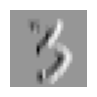

In [23]:
show_image(batch_features[0,0]);

The most important trick that PyTorch has up its sleeve is that it can use the GPU to do all this work in parallel—that is, applying multiple kernels, to multiple images, across multiple channels. Doing lots of work in parallel is critical to getting GPUs to work efficiently; if we did each of these operations one at a time, we'd often run hundreds of times slower (and if we used our manual convolution loop from the previous section, we'd be millions of times slower!). Therefore, to become a strong deep learning practitioner, one skill to practice is giving your GPU plenty of work to do at a time.

It would be nice to not lose those two pixels on each axis. The way we do that is to add *padding*, which is simply additional pixels added around the outside of our image. Most commonly, pixels of zeros are added. 

### Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image, which can make things a lot simpler when we construct our architectures. <<pad_conv>> shows how adding padding allows us to apply the kernels in the image corners.

<img src="images/chapter9_padconv.svg" id="pad_conv" caption="A convolution with padding" alt="A convolution with padding" width="600">

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map, as we can see in <<four_by_five_conv>>.

<img alt="A 4×4 kernel with 5×5 input and 2 pixels of padding" width="783" caption="A 4×4 kernel with 5×5 input and 2 pixels of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="four_by_five_conv" src="images/att_00029.png">

If we add a kernel of size `ks` by `ks` (with `ks` an odd number), the necessary padding on each side to keep the same shape is `ks//2`. An even number for `ks` would require a different amount of padding on the top/bottom and left/right, but in practice we almost never use an even filter size.

So far, when we have applied the kernel to the grid, we have moved it one pixel over at a time. But we can jump further; for instance, we could move over two pixels after each kernel application, as in <<three_by_five_conv>>. This is known as a *stride-2* convolution. The most common kernel size in practice is 3×3, and the most common padding is 1. As you'll see, stride-2 convolutions are useful for decreasing the size of our outputs, and stride-1 convolutions are useful for adding layers without changing the output size.

<img alt="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding" width="774" caption="A 3×3 kernel with 5×5 input, stride-2 convolution, and 1 pixel of padding (courtesy of Vincent Dumoulin and Francesco Visin)" id="three_by_five_conv" src="images/att_00030.png">

In an image of size `h` by `w`, using a padding of 1 and a stride of 2 will give us a result of size `(h+1)//2` by `(w+1)//2`. The general formula for each dimension is `(n + 2*pad - ks)//stride + 1`, where `pad` is the padding, `ks`, the size of our kernel, and `stride` is the stride.

Let's now take a look at how the pixel values of the result of our convolutions are computed.

### Understanding the Convolution Equations

To explain the math behind convolutions, fast.ai student Matt Kleinsmith came up with the very clever idea of showing [CNNs from different viewpoints](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c). In fact, it's so clever, and so helpful, we're going to show it here too!

Here's our 3×3 pixel image, with each pixel labeled with a letter:

<img alt="The image" width="75" src="images/att_00032.png">

And here's our kernel, with each weight labeled with a Greek letter:

<img alt="The kernel" width="55" src="images/att_00033.png">

Since the filter fits in the image four times, we have four results:

<img alt="The activations" width="52" src="images/att_00034.png">

<<apply_kernel>> shows how we applied the kernel to each section of the image to yield each result.

<img alt="Applying the kernel" width="366" caption="Applying the kernel" id="apply_kernel" src="images/att_00035.png">

The equation view is in <<eq_view>>.

<img alt="The equation" width="436" caption="The equation" id="eq_view" src="images/att_00036.png">

Notice that the bias term, *b*, is the same for each section of the image. You can consider the bias as part of the filter, just like the weights (α, β, γ, δ) are part of the filter.

Here's an interesting insight—a convolution can be represented as a special kind of matrix multiplication, as illustrated in <<conv_matmul>>. The weight matrix is just like the ones from traditional neural networks. However, this weight matrix has two special properties:

1. The zeros shown in gray are untrainable. This means that they’ll stay zero throughout the optimization process.
1. Some of the weights are equal, and while they are trainable (i.e., changeable), they must remain equal. These are called *shared weights*.

The zeros correspond to the pixels that the filter can't touch. Each row of the weight matrix corresponds to one application of the filter.

<img alt="Convolution as matrix multiplication" width="683" caption="Convolution as matrix multiplication" id="conv_matmul" src="images/att_00038.png">

Now that we understand what a convolution is, let's use them to build a neural net.

## Our First Convolutional Neural Network

There is no reason to believe that some particular edge filters are the most useful kernels for image recognition. Furthermore, we've seen that in later layers convolutional kernels become complex transformations of features from lower levels, but we don't have a good idea of how to manually construct these.

Instead, it would be best to learn the values of the kernels. We already know how to do this—SGD! In effect, the model will learn the features that are useful for classification.

When we use convolutions instead of (or in addition to) regular linear layers we create a *convolutional neural network* (CNN).

### Creating the CNN

Let's go back to the  basic neural network we had in <<chapter_mnist_basics>>. It was defined like this:

In [24]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

We can view a model's definition:

In [25]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

We now want to create a similar architecture to this linear model, but using convolutional layers instead of linear. `nn.Conv2d` is the module equivalent of `F.conv2d`. It's more convenient than `F.conv2d` when creating an architecture, because it creates the weight matrix for us automatically when we instantiate it.

Here's a possible architecture:

In [26]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

One thing to note here is that we didn't need to specify 28×28 as the input size. That's because a linear layer needs a weight in the weight matrix for every pixel, so it needs to know how many pixels there are, but a convolution is applied over each pixel automatically. The weights only depend on the number of input and output channels and the kernel size, as we saw in the previous section.

Think about what the output shape is going to be, then let's try it and see:

In [27]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This is not something we can use to do classification, since we need a single output activation per image, not a 28×28 map of activations. One way to deal with this is to use enough stride-2 convolutions such that the final layer is size 1. That is, after one stride-2 convolution the size will be 14×14, after two it will be 7×7, then 4×4, 2×2, and finally size 1.

Let's try that now. First, we'll define a function with the basic parameters we'll use in each convolution:

In [28]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

> important: Refactoring: Refactoring parts of your neural networks like this makes it much less likely you'll get errors due to inconsistencies in your architectures, and makes it more obvious to the reader which parts of your layers are actually changing.

When we use a stride-2 convolution, we often increase the number of features at the same time. This is because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time.

> jargon: channels and features: These two terms are largely used interchangeably, and refer to the size of the second axis of a weight matrix, which is, the number of activations per grid cell after a convolution. _Features_ is never used to refer to the input data, but _channels_ can refer to either the input data (generally channels are colors) or activations inside the network.

Here is how we can build a simple CNN:

In [29]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

> j: I like to add comments like the ones here after each convolution to show how large the activation map will be after each layer. These comments assume that the input size is 28*28

Now the network outputs two activations, which map to the two possible levels in our labels:

In [30]:
simple_cnn(xb).shape

torch.Size([64, 2])

We can now create our `Learner`:

In [31]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

To see exactly what's going on in the model, we can use `summary`:

In [32]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Note that the output of the final `Conv2d` layer is `64x2x1x1`. We need to remove those extra `1x1` axes; that's what `Flatten` does. It's basically the same as PyTorch's `squeeze` method, but as a module.

Let's see if this trains! Since this is a deeper network than we've built from scratch before, we'll use a lower learning rate and more epochs:

In [33]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061058,0.037444,0.986261,02:58
1,0.022820,0.021864,0.992149,01:21


Success! It's getting closer to the `resnet18` result we had, although it's not quite there yet, and it's taking more epochs, and we're needing to use a lower learning rate. We still have a few more tricks to learn, but we're getting closer and closer to being able to create a modern CNN from scratch.

### Understanding Convolution Arithmetic

We can see from the summary that we have an input of size `64x1x28x28`. The axes are `batch,channel,height,width`. This is often represented as `NCHW` (where `N` refers to batch size). Tensorflow, on the other hand, uses `NHWC` axis order. The first layer is:

In [34]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

So we have 1 input channel, 4 output channels, and a 3×3 kernel. Let's check the weights of the first convolution:

In [35]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

The summary shows we have 40 parameters, and `4*1*3*3` is 36. What are the other four parameters? Let's see what the bias contains:

In [36]:
m[0].bias.shape

torch.Size([4])

We can now use this information to clarify our statement in the previous section: "When we use a stride-2 convolution, we often increase the number of features because we're decreasing the number of activations in the activation map by a factor of 4; we don't want to decrease the capacity of a layer by too much at a time."

There is one bias for each channel. (Sometimes channels are called *features* or *filters* when they are not input channels.) The output shape is `64x4x14x14`, and this will therefore become the input shape to the next layer. The next layer, according to `summary`, has 296 parameters. Let's ignore the batch axis to keep things simple. So for each of `14*14=196` locations we are multiplying `296-8=288` weights (ignoring the bias for simplicity), so that's `196*288=56_448` multiplications at this layer. The next layer will have `7*7*(1168-16)=56_448` multiplications.

What happened here is that our stride-2 convolution halved the *grid size* from `14x14` to `7x7`, and we doubled the *number of filters* from 8 to 16, resulting in no overall change in the amount of computation. If we left the number of channels the same in each stride-2 layer, the amount of computation being done in the net would get less and less as it gets deeper. But we know that the deeper layers have to compute semantically rich features (such as eyes or fur), so we wouldn't expect that doing *less* computation would make sense.

Another way to think of this is based on receptive fields.

### Receptive Fields

The *receptive field* is the area of an image that is involved in the calculation of a layer. On the [book's website](https://book.fast.ai/), you'll find an Excel spreadsheet called *conv-example.xlsx* that shows the calculation of two stride-2 convolutional layers using an MNIST digit. Each layer has a single kernel. <<preced1>> shows what we see if we click on one of the cells in the *conv2* section, which shows the output of the second convolutional layer, and click *trace precedents*.

<img alt="Immediate precedents of conv2 layer" width="308" caption="Immediate precedents of Conv2 layer" id="preced1" src="images/att_00068.png">

Here, the cell with the green border is the cell we clicked on, and the blue highlighted cells are its *precedents*—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right). Let's now click *trace precedents* again, to see what cells are used to calculate these inputs. <<preced2>> shows what happens.

<img alt="Secondary precedents of conv2 layer" width="601" caption="Secondary precedents of Conv2 layer" id="preced2" src="images/att_00069.png">

In this example, we have just two convolutional layers, each of stride 2, so this is now tracing right back to the input image. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This 7×7 area is the *receptive field* in the input of the green activation in Conv2. We can also see that a second filter kernel is needed now, since we have two layers.

As you see from this example, the deeper we are in the network (specifically, the more stride-2 convs we have before a layer), the larger the receptive field for an activation in that layer. A large receptive field means that a large amount of the input image is used to calculate each activation in that layer is. We now know that in the deeper layers of the network we have semantically rich features, corresponding to larger receptive fields. Therefore, we'd expect that we'd need more weights for each of our features to handle this increasing complexity. This is another way of saying the same thing we mentioned in the previous section: when we introduce a stride-2 conv in our network, we should also increase the number of channels.

When writing this particular chapter, we had a lot of questions we needed answers for, to be able to explain CNNs to you as best we could. Believe it or not, we found most of the answers on Twitter. We're going to take a quick break to talk to you about that now, before we move on to color images.

### A Note About Twitter

We are not, to say the least, big users of social networks in general. But our goal in writing this book is to help you become the best deep learning practitioner you can, and we would be remiss not to mention how important Twitter has been in our own deep learning journeys.

You see, there's another part of Twitter, far away from Donald Trump and the Kardashians, which is the part of Twitter where deep learning researchers and practitioners talk shop every day. As we were writing this section, Jeremy wanted to double-check that what we were saying about stride-2 convolutions was accurate, so he asked on Twitter:

<img alt="twitter 1" width="500" src="images/att_00064.png">

A few minutes later, this answer popped up:

<img alt="twitter 2" width="500" src="images/att_00065.png">

Christian Szegedy is the first author of [Inception](https://arxiv.org/pdf/1409.4842.pdf), the 2014 ImageNet winner and source of many key insights used in modern neural networks. Two hours later, this appeared:

<img alt="twitter 3" width="500" src="images/att_00066.png">

Do you recognize that name? You saw it in <<chapter_production>>, when we were talking about the Turing Award winners who established the foundations of deep learning today!

Jeremy also asked on Twitter for help checking our description of label smoothing in <<chapter_sizing_and_tta>> was accurate, and got a response again from directly from Christian Szegedy (label smoothing was originally introduced in the Inception paper):

<img alt="twitter 4" width="500" src="images/att_00067.png">

Many of the top people in deep learning today are Twitter regulars, and are very open about interacting with the wider community. One good way to get started is to look at a list of Jeremy's [recent Twitter likes](https://twitter.com/jeremyphoward/likes), or [Sylvain's](https://twitter.com/GuggerSylvain/likes). That way, you can see a list of Twitter users that we think have interesting and useful things to say.

Twitter is the main way we both stay up to date with interesting papers, software releases, and other deep learning news. For making connections with the deep learning community, we recommend getting involved both in the [fast.ai forums](https://forums.fast.ai) and on Twitter.

That said, let's get back to the meat of this chapter. Up until now, we have only shown you examples of pictures in black and white, with one value per pixel. In practice, most colored images have three values per pixel to define their color. We'll look at working with color images next.

## Color Images

A colour picture is a rank-3 tensor:

In [37]:
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

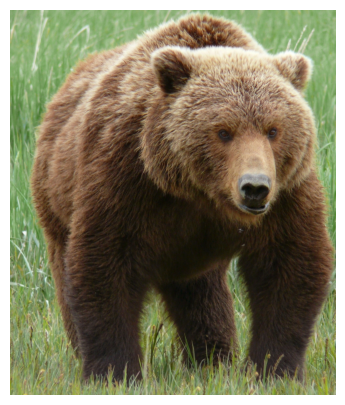

In [38]:
show_image(im);

The first axis contains the channels, red, green, and blue:

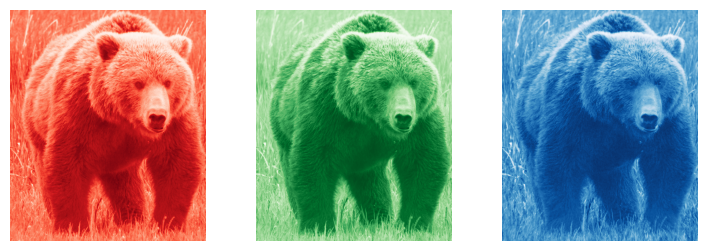

In [39]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

We saw what the convolution operation was for one filter on one channel of the image (our examples were done on a square). A convolutional layer will take an image with a certain number of channels (three for the first layer for regular RGB color images) and output an image with a different number of channels. Like our hidden size that represented the numbers of neurons in a linear layer, we can decide to have as many filters as we want, and each of them will be able to specialize, some to detect horizontal edges, others to detect vertical edges and so forth, to give something like we studied in <<chapter_production>>.

In one sliding window, we have a certain number of channels and we need as many filters (we don't use the same kernel for all the channels). So our kernel doesn't have a size of 3 by 3, but `ch_in` (for channels in) is 3 by 3. On each channel, we multiply the elements of our window by the elements of the coresponding filter, then sum the results (as we saw before) and sum over all the filters. In the example given in <<rgbconv>>, the result of our conv layer on that window is red + green + blue.

<img src="images/chapter9_rgbconv.svg" id="rgbconv" caption="Convolution over an RGB image" alt="Convolution over an RGB image" width="550">

So, in order to apply a convolution to a color picture we require a kernel tensor with a size that matches the first axis. At each location, the corresponding parts of the kernel and the image patch are multiplied together.

These are then all added together, to produce a single number, for each grid location, for each output feature, as shown in <<rgbconv2>>.

<img src="images/chapter9_rgb_conv_stack.svg" id="rgbconv2" caption="Adding the RGB filters" alt="Adding the RGB filters" width="500">

Then we have `ch_out` filters like this, so in the end, the result of our convolutional layer will be a batch of images with `ch_out` channels and a height and width given by the formula outlined earlier. This give us `ch_out` tensors of size `ch_in x ks x ks` that we represent in one big tensor of four dimensions. In PyTorch, the order of the dimensions for those weights is `ch_out x ch_in x ks x ks`.

Additionally, we may want to have a bias for each filter. In the preceding example, the final result for our convolutional layer would be $y_{R} + y_{G} + y_{B} + b$ in that case. Like in a linear layer, there are as many bias as we have kernels, so the biases is a vector of size `ch_out`.

There are no special mechanisms required when setting up a CNN for training with color images. Just make sure your first layer has three inputs.

There are lots of ways of processing color images. For instance, you can change them to black and white, change from RGB to HSV (hue, saturation, and value) color space, and so forth. In general, it turns out experimentally that changing the encoding of colors won't make any difference to your model results, as long as you don't lose information in the transformation. So, transforming to black and white is a bad idea, since it removes the color information entirely (and this can be critical; for instance, a pet breed may have a distinctive color); but converting to HSV generally won't make any difference.

Now you know what those pictures in <<chapter_intro>> of "what a neural net learns" from the [Zeiler and Fergus paper](https://arxiv.org/abs/1311.2901) mean! This is their picture of some of the layer 1 weights which we showed:

<img alt="Layer 1 kernels found by Zeiler and Fergus" width="120" src="images/att_00031.png">

This is taking the three slices of the convolutional kernel, for each output feature, and displaying them as images. We can see that even though the creators of the neural net never explicitly created kernels to find edges, for instance, the neural net automatically discovered these features using SGD.

Now let's see how we can train these CNNs, and show you all the techniques fastai uses under the hood for efficient training.

## Improving Training Stability

Since we are so good at recognizing 3s from 7s, let's move on to something harder—recognizing all 10 digits. That means we'll need to use `MNIST` instead of `MNIST_SAMPLE`:

In [40]:
path = untar_data(URLs.MNIST)

In [41]:
#hide
Path.BASE_PATH = path

In [42]:
path.ls()

(#2) [Path('training'),Path('testing')]

The data is in two folders named *training* and *testing*, so we have to tell `GrandparentSplitter` about that (it defaults to `train` and `valid`). We did do that in the `get_dls` function, which we create to make it easy to change our batch size later:

In [43]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Remember, it's always a good idea to look at your data before you use it:

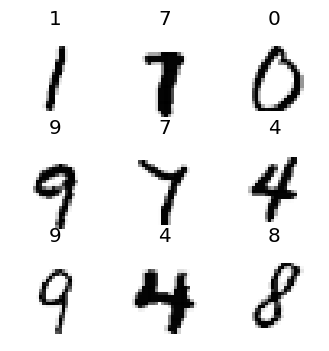

In [44]:
dls.show_batch(max_n=9, figsize=(4,4))

Now that we have our data ready, we can train a simple model on it.

### A Simple Baseline

Earlier in this chapter, we built a model based on a `conv` function like this:

In [45]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

Let's start with a basic CNN as a baseline. We'll use the same one as earlier, but with one tweak: we'll use more activations. Since we have more numbers to differentiate, it's likely we will need to learn more filters.

As we discussed, we generally want to double the number of filters each time we have a stride-2 layer. One way to increase the number of filters throughout our network is to double the number of activations in the first layer–then every layer after that will end up twice as big as in the previous version as well.

But there is a subtle problem with this. Consider the kernel that is being applied to each pixel. By default, we use a 3×3-pixel kernel. That means that there are a total of 3×3 = 9 pixels that the kernel is being applied to at each location. Previously, our first layer had four output filters. That meant that there were four values being computed from nine pixels at each location. Think about what happens if we double this output to eight filters. Then when we apply our kernel we will be using nine pixels to calculate eight numbers. That means it isn't really learning much at all: the output size is almost the same as the input size. Neural networks will only create useful features if they're forced to do so—that is, if the number of outputs from an operation is significantly smaller than the number of inputs.

To fix this, we can use a larger kernel in the first layer. If we use a kernel of 5×5 pixels then there are 25 pixels being used at each kernel application. Creating eight filters from this will mean the neural net will have to find some useful features:

In [46]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

As you'll see in a moment, we can look inside our models while they're training in order to try to find ways to make them train better. To do this we use the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer (as we've seen, callbacks are used to add behavior to the training loop; we'll explore how they work in <<chapter_accel_sgd>>):

In [47]:
from fastai.callback.hook import *

We want to train quickly, so that means training at a high learning rate. Let's see how we go at 0.06:

In [48]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [49]:
learn = fit()

/home/flavio/repositories/other/fastbook/.venv/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.304476,2.306587,0.113500,07:44


This didn't train at all well! Let's find out why.

One handy feature of the callbacks passed to `Learner` is that they are made available automatically, with the same name as the callback class, except in `snake_case`. So, our `ActivationStats` callback can be accessed through `activation_stats`. I'm sure you remember `learn.recorder`... can you guess how that is implemented? That's right, it's a callback called `Recorder`!

`ActivationStats` includes some handy utilities for plotting the activations during training. `plot_layer_stats(idx)` plots the mean and standard deviation of the activations of layer number *`idx`*, along with the percentage of activations near zero. Here's the first layer's plot:

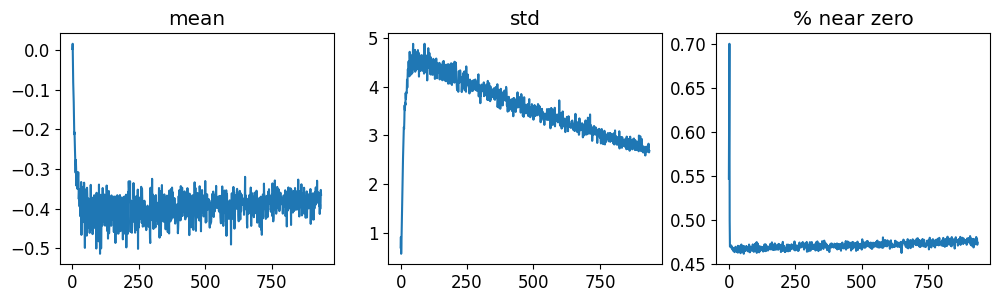

In [50]:
learn.activation_stats.plot_layer_stats(0)

Generally our model should have a consistent, or at least smooth, mean and standard deviation of layer activations during training. Activations near zero are particularly problematic, because it means we have computation in the model that's doing nothing at all (since multiplying by zero gives zero). When you have some zeros in one layer, they will therefore generally carry over to the next layer... which will then create more zeros. Here's the penultimate layer of our network:

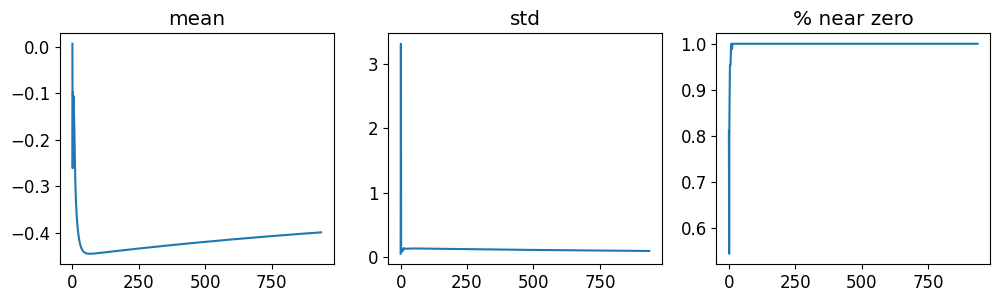

In [51]:
learn.activation_stats.plot_layer_stats(-2)

As expected, the problems get worse towards the end of the network, as the instability and zero activations compound over layers. Let's look at what we can do to make training more stable.

### Increase Batch Size

One way to make training more stable is to increase the batch size. Larger batches have gradients that are more accurate, since they're calculated from more data. On the downside, though, a larger batch size means fewer batches per epoch, which means less opportunities for your model to update weights. Let's see if a batch size of 512 helps:

In [52]:
dls = get_dls(512)

In [53]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,1.336730,0.989393,0.641500,02:09


Let's see what the penultimate layer looks like:

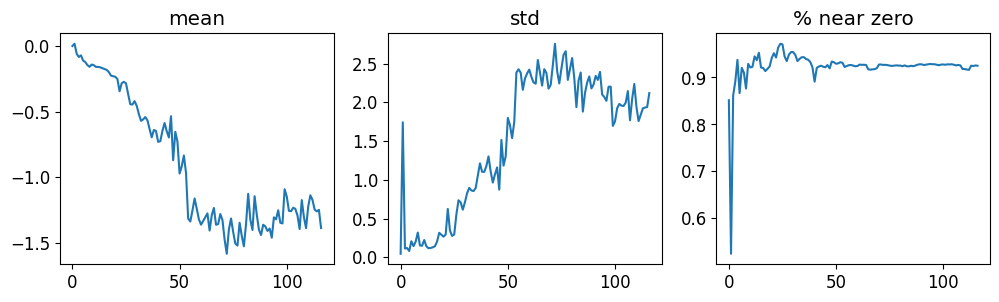

In [54]:
learn.activation_stats.plot_layer_stats(-2)

Again, we've got most of our activations near zero. Let's see what else we can do to improve training stability.

### 1cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

Leslie Smith (yes, the same guy that invented the learning rate finder!) developed this idea in his article ["Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates"](https://arxiv.org/abs/1708.07120). He designed a schedule for learning rate separated into two phases: one where the learning rate grows from the minimum value to the maximum value (*warmup*), and one where it decreases back to the minimum value (*annealing*). Smith called this combination of approaches *1cycle training*.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster—a phenomenon Smith named *super-convergence*.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

The second point is an interesting and subtle one; it is based on the observation that a model that generalizes well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalizes well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't jump straight to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimizer to gradually find smoother and smoother areas of our parameters by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we want to find the very best part of that area, which means we have to bring our learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. That is why it is the approach that is used by default for `fine_tune` in fastai.

In <<chapter_accel_sgd>> we'll learn all about *momentum* in SGD. Briefly, momentum is a technique where the optimizer takes a step not only in the direction of the gradients, but also that continues in the direction of previous steps. Leslie Smith introduced the idea of *cyclical momentums* in ["A Disciplined Approach to Neural Network Hyper-Parameters: Part 1"](https://arxiv.org/pdf/1803.09820.pdf). It suggests that the momentum varies in the opposite direction of the learning rate: when we are at high learning rates, we use less momentum, and we use more again in the annealing phase.

We can use 1cycle training in fastai by calling `fit_one_cycle`:

In [55]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [56]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.201250,0.070042,0.976900,02:15


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. `learn.recorder` (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

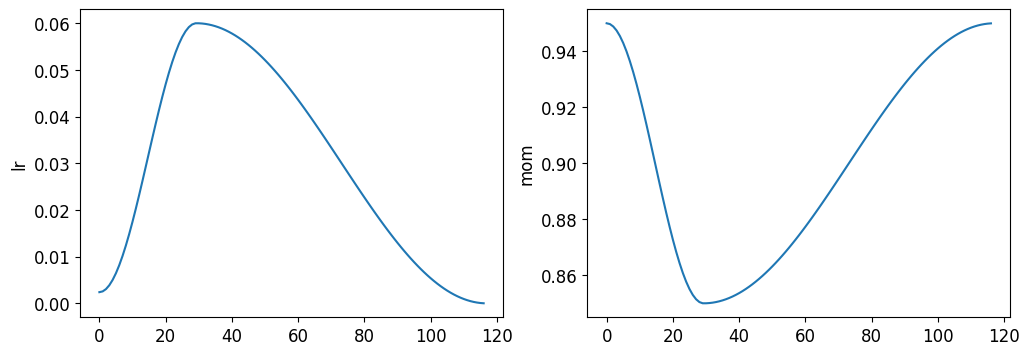

In [57]:
learn.recorder.plot_sched()

Smith's original 1cycle paper used a linear warmup and linear annealing. As you can see, we adapted the approach in fastai by combining it with another popular approach: cosine annealing. `fit_one_cycle` provides the following parameters you can adjust:

- `lr_max`:: The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a Python `slice` object containing the first and last layer group learning rates)
- `div`:: How much to divide `lr_max` by to get the starting learning rate
- `div_final`::  How much to divide `lr_max` by to get the ending learning rate
- `pct_start`:: What percentage of the batches to use for the warmup
- `moms`:: A tuple `(mom1,mom2,mom3)` where *`mom1`* is the initial momentum, *`mom2`* is the minimum momentum, and *`mom3`* is the final momentum

Let's take a look at our layer stats again:

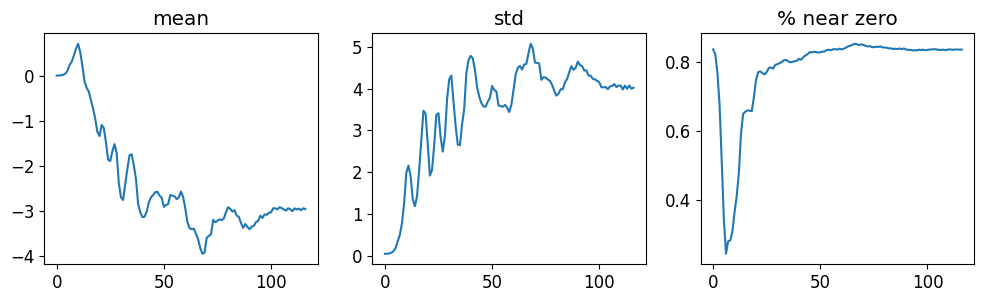

In [58]:
learn.activation_stats.plot_layer_stats(-2)

The percentage of near-zero weights is getting much better, although it's still quite high.

We can see even more about what's going on in our training using `color_dim`, passing it a layer index:

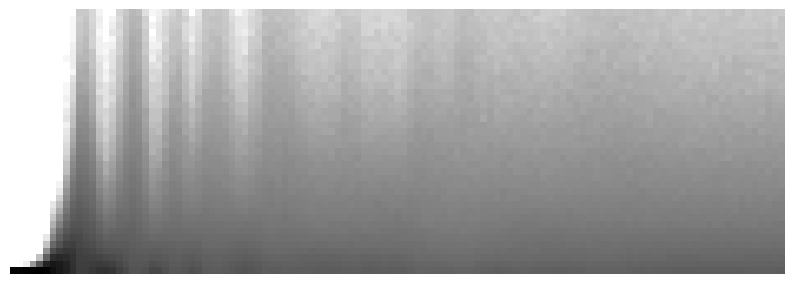

In [59]:
learn.activation_stats.color_dim(-2)

`color_dim` was developed by fast.ai in conjunction with a student, Stefano Giomo. Stefano, who refers to the idea as the *colorful dimension*, provides an [in-depth explanation](https://forums.fast.ai/t/the-colorful-dimension/42908) of the history and details behind the method. The basic idea is to create a histogram of the activations of a layer, which we would hope would follow a smooth pattern such as the normal distribution (colorful_dist).

<img src="images/colorful_dist.jpeg" id="colorful_dist" caption="Histogram in 'colorful dimension'" alt="Histogram in 'colorful dimension'" width="800">

To create `color_dim`, we take the histogram shown on the left here, and convert it into just the colored representation shown at the bottom. Then we flip it on its side, as shown on the right. We found that the distribution is clearer if we take the log of the histogram values. Then, Stefano describes:

> : The final plot for each layer is made by stacking the histogram of the activations from each batch along the horizontal axis. So each vertical slice in the visualisation represents the histogram of activations for a single batch. The color intensity corresponds to the height of the histogram, in other words the number of activations in each histogram bin.

<<colorful_summ>> shows how this all fits together.

<img src="images/colorful_summ.png" id="colorful_summ" caption="Summary of the colorful dimension (courtesy of Stefano Giomo)" alt="Summary of the colorful dimension" width="800">

This illustrates why log(f) is more colorful than *f* when *f* follows a normal distribution because taking a log changes the Gaussian in a quadratic, which isn't as narrow.

So with that in mind, let's take another look at the result for the penultimate layer:

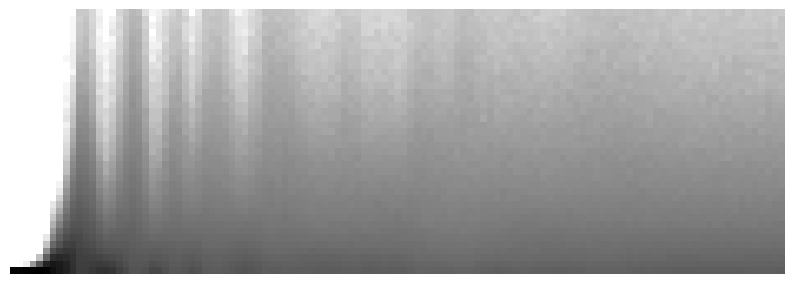

In [60]:
learn.activation_stats.color_dim(-2)

This shows a classic picture of "bad training." We start with nearly all activations at zero—that's what we see at the far left, with all the dark blue. The bright yellow at the bottom represents the near-zero activations. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again, and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

### Batch Normalization

To fix the slow training and poor final results we ended up with in the previous section, we need to fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training.

Sergey Ioffe and Christian Szegedy presented a solution to this problem in the 2015 paper ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167). In the abstract, they describe just the problem that we've seen:

> : Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their solution, they say is:

> : Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

The paper caused great excitement as soon as it was released, because it included the chart in <<batchnorm>>, which clearly demonstrated that batch normalization could train a model that was even more accurate than the current state of the art (the *Inception* architecture) and around 5x faster.

<img alt="Impact of batch normalization" width="553" caption="Impact of batch normalization (courtesy of Sergey Ioffe and Christian Szegedy)" id="batchnorm" src="images/att_00046.png">

Batch normalization (often just called *batchnorm*) works by taking an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations. However, this can cause problems because the network might want some activations to be really high in order to make accurate predictions. So they also added two learnable parameters (meaning they will be updated in the SGD step), usually called `gamma` and `beta`. After normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

That's why our activations can have any mean or variance, independent from the mean and standard deviation of the results of the previous layer. Those statistics are learned separately, making training easier on our model. The behavior is different during training and validation: during training, we use the mean and standard deviation of the batch to normalize the data, while during validation we instead use a running mean of the statistics calculated during training.

Let's add a batchnorm layer to `conv`:

In [61]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

and fit our model:

In [62]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

That's a great result! Let's take a look at `color_dim`:

In [ ]:
learn.activation_stats.color_dim(-4)

This is just what we hope to see: a smooth development of activations, with no "crashes." Batchnorm has really delivered on its promise here! In fact, batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.

An interesting observation about models containing batch normalization layers is that they tend to generalize better than models that don't contain them. Although we haven't as yet seen a rigorous analysis of what's going on here, most researchers believe that the reason for this is that batch normalization adds some extra randomness to the training process. Each mini-batch will have a somewhat different mean and standard deviation than other mini-batches. Therefore, the activations will be normalized by different values each time. In order for the model to make accurate predictions, it will have to learn to become robust to these variations. In general, adding additional randomization to the training process often helps.

Since things are going so well, let's train for a few more epochs and see how it goes. In fact, let's *increase* the learning rate, since the abstract of the batchnorm paper claimed we should be able to "train at much higher learning rates":

In [ ]:
learn = fit(5, lr=0.1)

At this point, I think it's fair to say we know how to recognize digits! It's time to move on to something harder...

## Conclusions

We've seen that convolutions are just a type of matrix multiplication, with two constraints on the weight matrix: some elements are always zero, and some elements are tied (forced to always have the same value). In <<chapter_intro>> we saw the eight requirements from the 1986 book *Parallel Distributed Processing*; one of them was "A pattern of connectivity among units." That's exactly what these constraints do: they enforce a certain pattern of connectivity.

These constraints allow us to use far fewer parameters in our model, without sacrificing the ability to represent complex visual features. That means we can train deeper models faster, with less overfitting. Although the universal approximation theorem shows that it should be *possible* to represent anything in a fully connected network in one hidden layer, we've seen now that in *practice* we can train much better models by being thoughtful about network architecture.

Convolutions are by far the most common pattern of connectivity we see in neural nets (along with regular linear layers, which we refer to as *fully connected*), but it's likely that many more will be discovered.

We've also seen how to interpret the activations of layers in the network to see whether training is going well or not, and how batchnorm helps regularize the training and makes it smoother. In the next chapter, we will use both of those layers to build the most popular architecture in computer vision: a residual network.

## Questionnaire

1. What is a "feature"?
1. Write out the convolutional kernel matrix for a top edge detector.
1. Write out the mathematical operation applied by a 3×3 kernel to a single pixel in an image.
1. What is the value of a convolutional kernel apply to a 3×3 matrix of zeros?
1. What is "padding"?
1. What is "stride"?
1. Create a nested list comprehension to complete any task that you choose.
1. What are the shapes of the `input` and `weight` parameters to PyTorch's 2D convolution?
1. What is a "channel"?
1. What is the relationship between a convolution and a matrix multiplication?
1. What is a "convolutional neural network"?
1. What is the benefit of refactoring parts of your neural network definition?
1. What is `Flatten`? Where does it need to be included in the MNIST CNN? Why?
1. What does "NCHW" mean?
1. Why does the third layer of the MNIST CNN have `7*7*(1168-16)` multiplications?
1. What is a "receptive field"?
1. What is the size of the receptive field of an activation after two stride 2 convolutions? Why?
1. Run *conv-example.xlsx* yourself and experiment with *trace precedents*.
1. Have a look at Jeremy or Sylvain's list of recent Twitter "like"s, and see if you find any interesting resources or ideas there.
1. How is a color image represented as a tensor?
1. How does a convolution work with a color input?
1. What method can we use to see that data in `DataLoaders`?
1. Why do we double the number of filters after each stride-2 conv?
1. Why do we use a larger kernel in the first conv with MNIST (with `simple_cnn`)?
1. What information does `ActivationStats` save for each layer?
1. How can we access a learner's callback after training?
1. What are the three statistics plotted by `plot_layer_stats`? What does the x-axis represent?
1. Why are activations near zero problematic?
1. What are the upsides and downsides of training with a larger batch size?
1. Why should we avoid using a high learning rate at the start of training?
1. What is 1cycle training?
1. What are the benefits of training with a high learning rate?
1. Why do we want to use a low learning rate at the end of training?
1. What is "cyclical momentum"?
1. What callback tracks hyperparameter values during training (along with other information)?
1. What does one column of pixels in the `color_dim` plot represent?
1. What does "bad training" look like in `color_dim`? Why?
1. What trainable parameters does a batch normalization layer contain?
1. What statistics are used to normalize in batch normalization during training? How about during validation?
1. Why do models with batch normalization layers generalize better?

### Further Research

1. What features other than edge detectors have been used in computer vision (especially before deep learning became popular)?
1. There are other normalization layers available in PyTorch. Try them out and see what works best. Learn about why other normalization layers have been developed, and how they differ from batch normalization.
1. Try moving the activation function after the batch normalization layer in `conv`. Does it make a difference? See what you can find out about what order is recommended, and why.